<h2>Data Analysis and Classification of Whether a New Client Will Subscribe to a Term Deposit.</h2>

DSCI 100 Final Project Notebook (Group Members 25: Armaan Kara, Daniel Lee, Leo Ng, Maddie Buss)

In [50]:
# SETUP CODE
library(repr)
library(tidyverse)
library(tidymodels)
install.packages("corrplot")
library(corrplot)
install.packages("pastecs")
library(pastecs)
options(repr.matrix.max.rows = 10)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



<h2>1) Introduction</h2>

Bank managers have been asking the same question for a long time. What sort of clients will subscribe to a term deposit? To solve this question, we have downloaded the “bank-full.csv” data set from the Portuguese banking institution to analyze the results and conduct the research. By using the KNN classification method, we aim to predict if the client will subscribe to a term deposit or not. 

"bank-full.csv” is a document representing the marketing efforts of the Portuguese banking institution. 21 variables are measured, with the classification variable being whether or not a client will subscribe to a term deposit. A term deposit is a fixed-term investment that contains the deposit of funds into an account at a financial institution and receives a certain amount of interest on the maturity date (Chen, 2020). This data was originally produced by researchers at the University Institute of Lisbon for a report highlighting a data-driven approach to predict the successfulness of bank telemarketing.

This dataset features 20 attributes regarding demographics (age, job, marital status), economic and educational situation (level of education, possession of a housing loan), and historical information’s relationship to the banking institution (last month of contact, outcome from previous marketing campaign). In order to make this prediction more effective and accurate, we have filtered out the 4 most important predictors after analysing the data correlation between the variables, and using these 4 variables as our predictor to conduct KNN classification analysis, and each of the variables contains 41188 observations, which makes the whole prediction more trustworthy and accurate. We will separate 75% of the data into the training set and 25% of the remaining into the testing set in order to find out the most suitable k-neighbour in our function. After identifying the correct "k" for the function, we will train a new classification model using the determined value of k which will be used to answer the following question:

Given a new client (a new row in the table), will the client subscribe to a term deposit or not? 

<h2>2a) Exploratory Data Analysis</h2>
The Bank Marketing data set contains roughly 45,000 observations and can be found on the UCI Machine Learning Repository under the Data Folder.

In [78]:
# Retrieving and preparing the dataset for classification
library(GGally)
# Set the seed to improve reproducibilty for generating random numbers
set.seed(7134) 
# Creating a temporary file to mitigate the creation of an unreadable file due to a compressed download
temp <- tempfile()

# Read the dataset and discard the unnecessary columns. It is labelled as bank_data
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip",temp)
bank_data <- read.table(unz(temp, "bank-full.csv"), sep=";", header=TRUE)
unlink(temp)
bank_data

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes


**Table 1: Original bank dataset downloaded from the web**

<h2>2b) Cleaning and Wrangling the Data</h2>



In [79]:
#Check the categorical variables for "unknown" values

job_unknowns <- count(bank_data, job) %>%
filter(job == "unknown")
marital_unknowns <- count(bank_data, marital) %>%
filter(marital == "unknown")
education_unknowns <- count(bank_data, education) %>%
filter(education == "unknown")
default_unknowns <- count(bank_data, default) %>%
filter(default == "unknown")
housing_unknowns <- count(bank_data, housing) %>%
filter(housing == "unknown")
loan_unknowns <- count(bank_data, loan) %>%
filter(loan == "unknown")
contact_unknowns <- count(bank_data, contact) %>%
filter(contact == "unknown")
month_unknowns <- count(bank_data, month) %>%
filter(month == "unknown")
poutcome_unknowns <- count(bank_data, poutcome) %>%
filter(poutcome == "unknown")

data_unknowns <- tribble(
    ~Column, ~Unknowns,
    "job",   job_unknowns[1, "n"],
    "marital",   marital_unknowns[1, "n"],
    "education", education_unknowns[1, "n"],
    "default",   default_unknowns[1, "n"],
    "housing",   housing_unknowns[1, "n"],
    "loan",   loan_unknowns[1, "n"],
    "contact", contact_unknowns[1, "n"],
    "month",   month_unknowns[1, "n"],
    "poutcome", poutcome_unknowns[1, "n"]
)
data_unknowns

Column,Unknowns
<chr>,<int>
job,288
marital,NA
education,1857
default,NA
housing,NA
loan,NA
contact,13020
month,NA
poutcome,36959


**Table 2: Counts of unknown values per column in the dataset**

From the table above, we can see that there are some rows with unknown values, but job and education have very few unknowns in relation to the total amount of observations. As suchm simply removing the rows with an unknown job or education level and 
keeping job and education as possible predictors would be best. Contact has quite a bit more unknowns at 13020, but even if we removed the rows with an unknown contact value, we would still have ~32000 observations which would be more than enough for
building our model. On the other hand, poutcome has a very large amount of unknowns at 36959, and removing the rows with an unknown poutcome would leave us with only around 8000 observations, which would definitely affect the accuracy of our model, so
poutcome will not be used as a possible predictor.

In [80]:
# Filter out any rows with unknown data
bank_data_filtered <- bank_data %>%
    filter(job != "unknown",
           marital != "unknown",
           education != "unknown",
           default != "unknown",
           housing != "unknown",
           loan != "unknown",
           contact != "unknown")

# Also make sure there aren't any "na" values in the dataset
bank_data_filtered <- bank_data_filtered[complete.cases(bank_data_filtered), ]

bank_data_filtered

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,27,management,single,secondary,no,35,no,no,cellular,4,jul,255,1,-1,0,unknown,no
2,54,blue-collar,married,primary,no,466,no,no,cellular,4,jul,297,1,-1,0,unknown,no
3,43,blue-collar,married,secondary,no,105,no,yes,cellular,4,jul,668,2,-1,0,unknown,no
4,31,technician,single,secondary,no,19,no,no,telephone,4,jul,65,2,-1,0,unknown,no
5,27,technician,single,secondary,no,126,yes,yes,cellular,4,jul,436,4,-1,0,unknown,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
30903,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
30904,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
30905,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes


**Table 3: Tidy dataset after wrangling the data.** Note the decrease in rows (30907 compared to the original 45211) due to removing rows with unknowns

The last cleaning step involves splitting the dataset observations into training and testing data. We will first split the data, and then convert the the variables into numerical values. The reason the conversion is done after the split is because we will be using visualizations to analyze the training dataset, and so we will need it with both its original categorical variables, and the converted numerical variables

In [81]:
# Set the seed
set.seed(7134) 

# Split the dataset into training and testing sets
bank_split <- initial_split(bank_data_filtered, prop = 0.75, strata = y)  
 
# Transform categorical predictors to numbers as required for classification.
# Also transform the integer predictors to doubles for consistency
bank_test <- testing(bank_split) %>%
    as_tibble() %>%
    select(!poutcome) %>%
    mutate(y = as_factor(y),
           age = as.double(age),
           job = as.double(unclass(as_factor(job))),
           marital = as.double(unclass(as_factor(marital))),
           education = as.double(unclass(as_factor(education))),
           default = as.double(unclass(as_factor(default))),
           balance = as.double(balance),
           housing = as.double(unclass(as_factor(housing))),
           loan = as.double(unclass(as_factor(loan))),
           contact = as.double(unclass(as_factor(contact))),
           day = as.double(day),
           month = as.double(unclass(as_factor(month))),
           duration = as.double(duration),
           campaign = as.double(campaign),
           pdays = as.double(pdays),
           previous = as.double(previous))
bank_test

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
43,1,1,1,1,105,1,1,1,4,1,668,2,-1,0,no
44,2,1,2,1,1146,1,2,1,4,1,178,2,-1,0,no
54,2,1,1,1,187,1,1,1,4,1,273,3,-1,0,no
44,3,1,1,1,93,1,2,1,7,1,125,2,-1,0,no
51,2,1,1,1,216,1,2,1,7,1,615,2,-1,0,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
36,10,2,1,1,1224,2,2,1,12,4,482,1,374,1,yes
66,9,1,1,1,3409,1,2,1,15,4,414,2,27,6,no
34,2,1,1,1,133,1,2,1,15,4,401,2,187,5,yes


**Table 4: Testing dataset from splitting the original dataset**

We decided to split the data into 75% train and 25% test this is because since we have around 45,000 observations we have enough data to train the classifier effectively and then still have enough to test its accuracy.

In [82]:
bank_train_categorical <- training(bank_split)  

# Transform categorical predictors to numbers as required for classification.
# Also transform the integer predictors to doubles for consistency
bank_train <- as_tibble(bank_train_categorical) %>%
    select(!poutcome) %>%
    mutate(y = as_factor(y),
           age = as.double(age),
           job = as.double(unclass(as_factor(job))),
           marital = as.double(unclass(as_factor(marital))),
           education = as.double(unclass(as_factor(education))),
           default = as.double(unclass(as_factor(default))),
           balance = as.double(balance),
           housing = as.double(unclass(as_factor(housing))),
           loan = as.double(unclass(as_factor(loan))),
           contact = as.double(unclass(as_factor(contact))),
           day = as.double(day),
           month = as.double(unclass(as_factor(month))),
           duration = as.double(duration),
           campaign = as.double(campaign),
           pdays = as.double(pdays),
           previous = as.double(previous))
bank_train

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
27,1,1,1,1,35,1,1,1,4,1,255,1,-1,0,no
54,2,2,2,1,466,1,1,1,4,1,297,1,-1,0,no
31,3,1,1,1,19,1,1,2,4,1,65,2,-1,0,no
27,3,1,1,1,126,2,2,1,4,1,436,4,-1,0,no
28,2,1,1,1,-127,2,1,1,4,1,1044,3,-1,0,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
51,3,2,3,1,825,1,1,1,17,4,977,3,-1,0,yes
71,9,3,2,1,1729,1,1,1,17,4,456,2,-1,0,yes
72,9,2,1,1,5715,1,1,1,17,4,1127,5,184,3,yes


**Table 5: Training dataset from splitting the original dataset**

<h2>2c) Summarizing the Data</h2>
Now that the datset is wrangled and cleaned, we visualzie our data to assess the quality of each of the predictors. Below, we summarize our cleaned data set using a table which contains various statistical features for each column corresponding to a numerical variable:

In [83]:
df2_summary <- data.frame(unclass(summary(bank_train)), check.names = FALSE, stringsAsFactors = FALSE)
df2_summary

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
X,Min. :18.00,Min. : 1.000,Min. :1.000,Min. :1.000,Min. :1.000,Min. :-8019,Min. :1.0,Min. :1.000,Min. :1.000,Min. : 1.00,Min. : 1.000,Min. : 0.0,Min. : 1.00,Min. : -1,Min. : 0.0000,no :19796
X.1,1st Qu.:32.00,1st Qu.: 2.000,1st Qu.:1.000,1st Qu.:1.000,1st Qu.:1.000,1st Qu.: 81,1st Qu.:1.0,1st Qu.:1.000,1st Qu.:1.000,1st Qu.: 9.00,1st Qu.: 2.000,1st Qu.: 103.0,1st Qu.: 1.00,1st Qu.: -1,1st Qu.: 0.0000,yes: 3385
X.2,Median :39.00,Median : 3.000,Median :2.000,Median :1.000,Median :1.000,Median : 473,Median :1.0,Median :1.000,Median :1.000,Median :17.00,Median : 4.000,Median : 181.0,Median : 2.00,Median : -1,Median : 0.0000,NA
X.3,Mean :40.91,Mean : 3.774,Mean :1.824,Mean :1.826,Mean :1.017,Mean : 1405,Mean :1.5,Mean :1.167,Mean :1.087,Mean :16.01,Mean : 5.205,Mean : 260.9,Mean : 2.75,Mean : 56,Mean : 0.8178,NA
X.4,3rd Qu.:48.00,3rd Qu.: 5.000,3rd Qu.:2.000,3rd Qu.:3.000,3rd Qu.:1.000,3rd Qu.: 1504,3rd Qu.:2.0,3rd Qu.:1.000,3rd Qu.:1.000,3rd Qu.:21.00,3rd Qu.: 9.000,3rd Qu.: 322.0,3rd Qu.: 3.00,3rd Qu.: 10,3rd Qu.: 1.0000,NA
X.5,Max. :95.00,Max. :11.000,Max. :3.000,Max. :3.000,Max. :2.000,Max. :98417,Max. :2.0,Max. :2.000,Max. :2.000,Max. :31.00,Max. :12.000,Max. :3422.0,Max. :50.00,Max. :871,Max. :275.0000,NA


**Table 6: Summary of the variables in the dataset**

The above table provides some insight into each of the predictors, giving a rough idea of the distribution of each of them. We can also see the total number of rows with "no" and "yes" values for y, which we will focus on more after the following visualizations

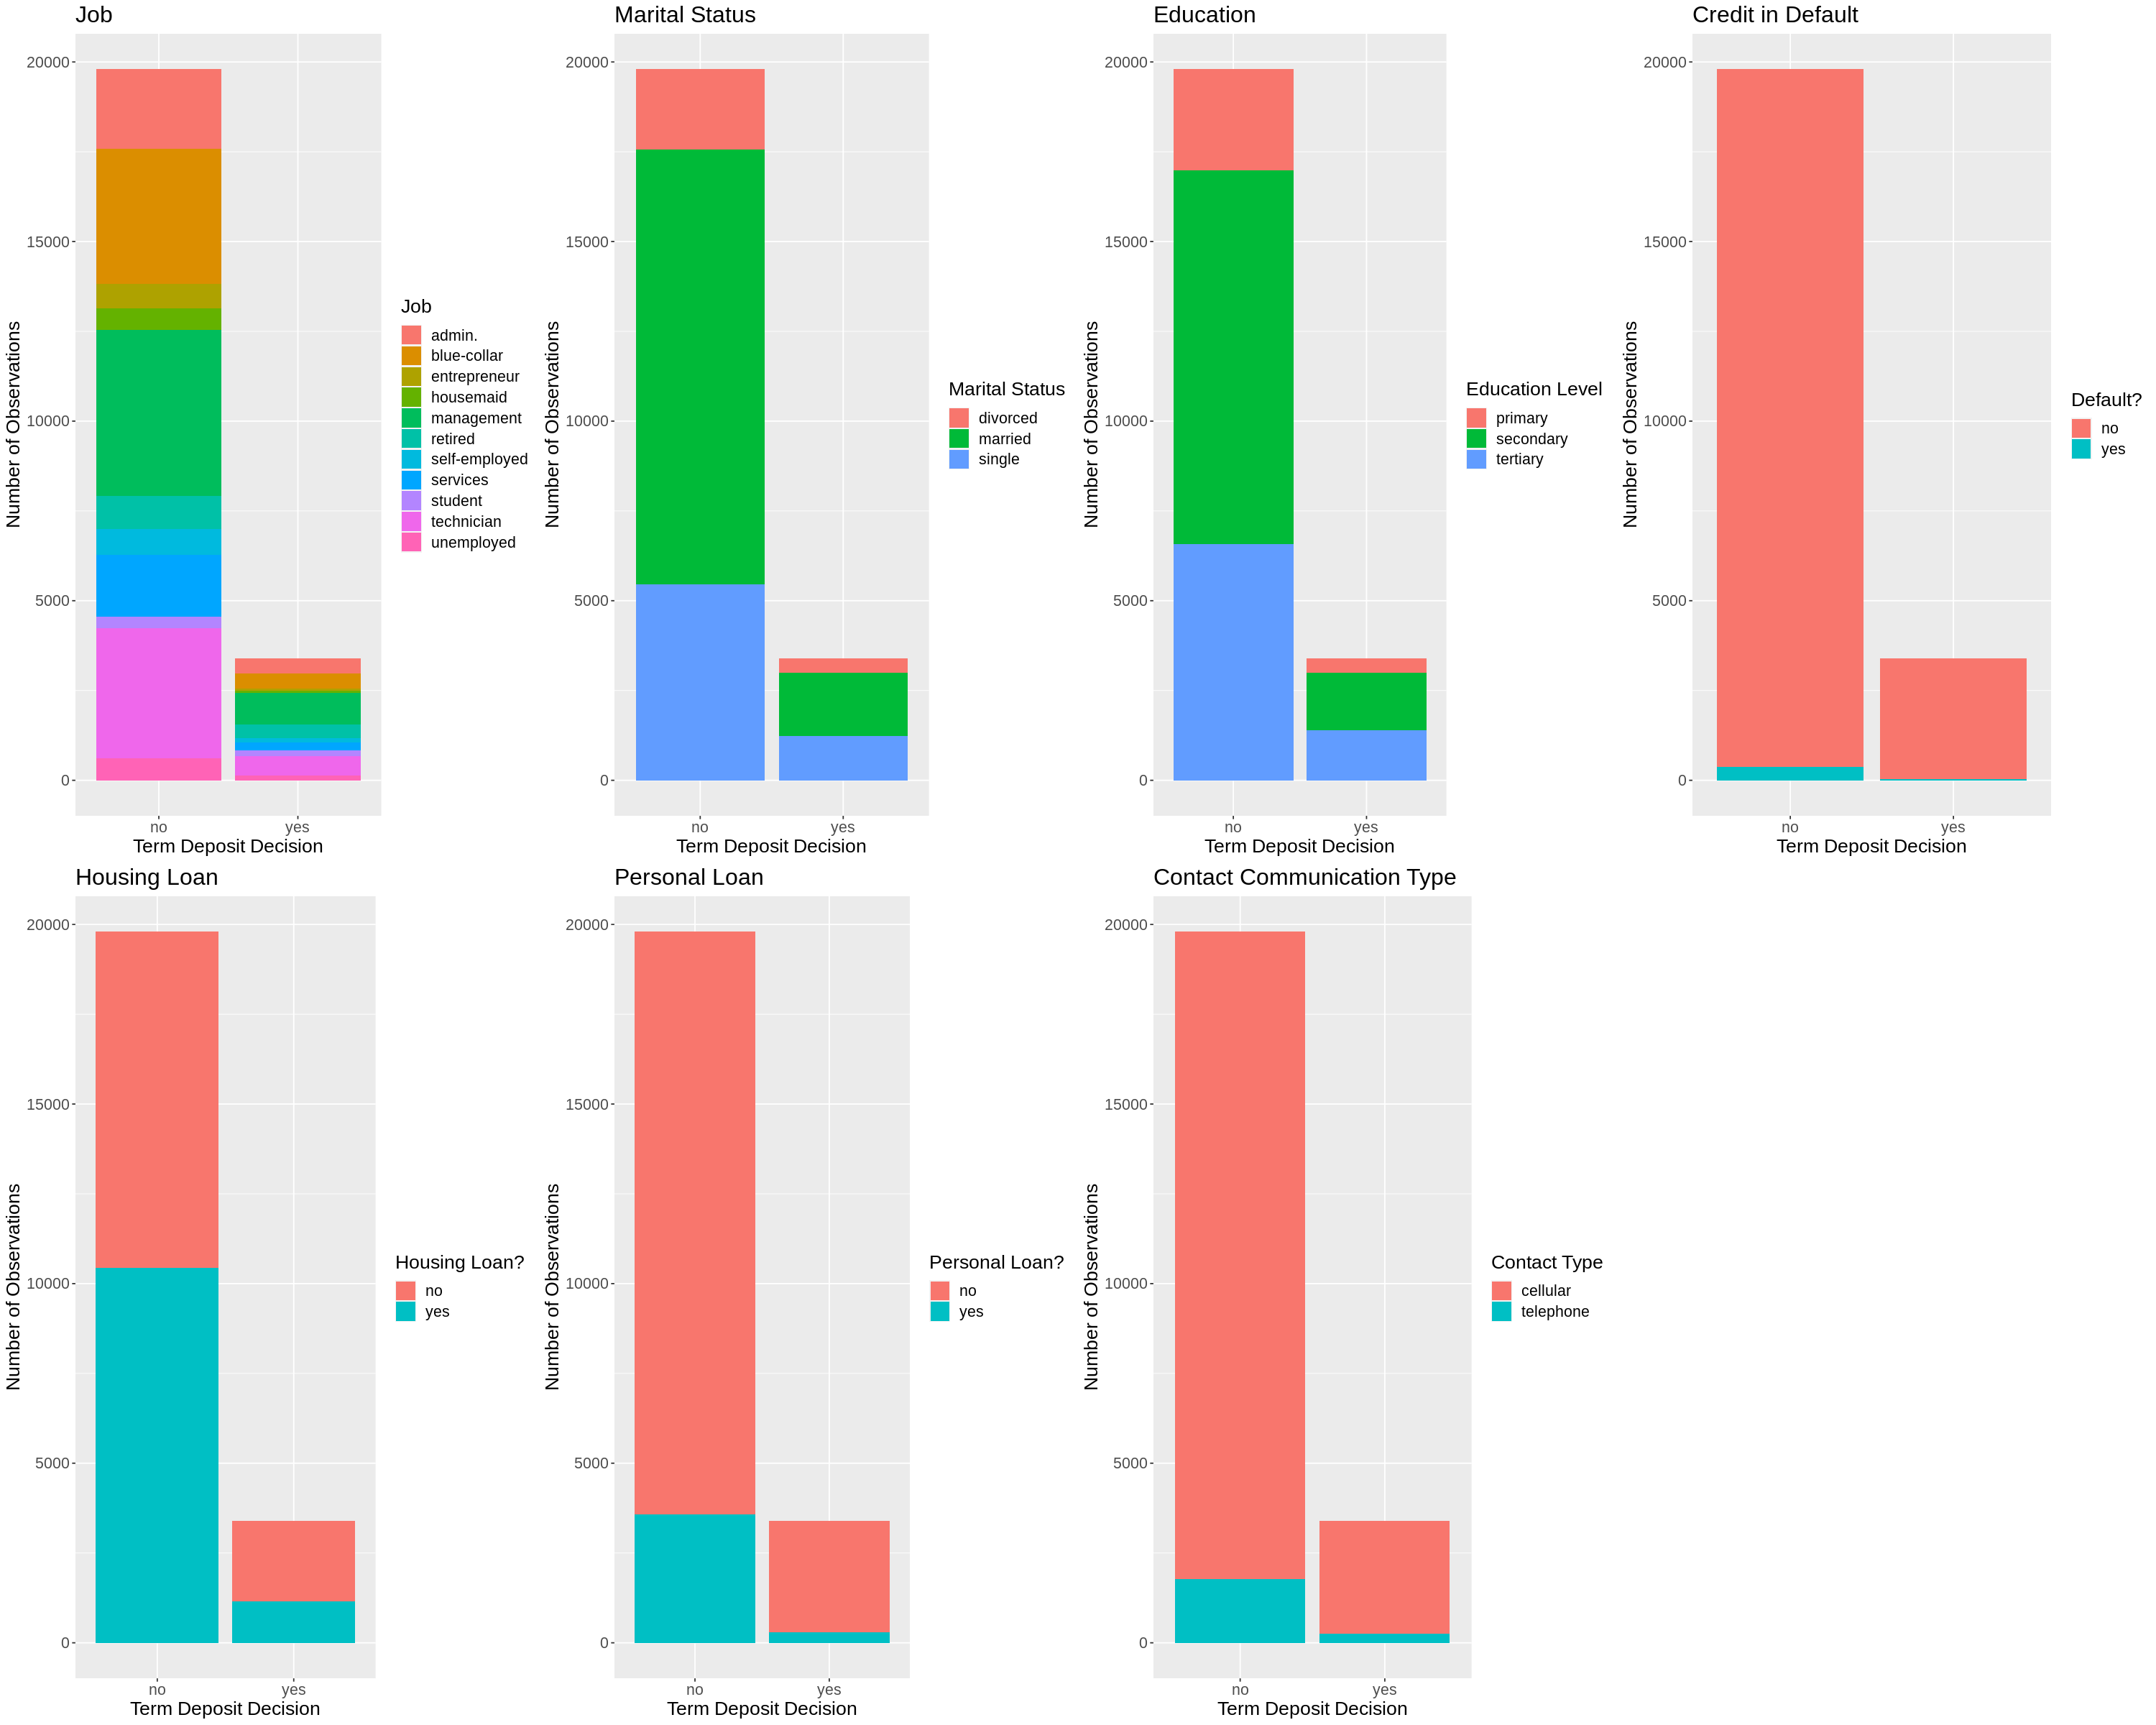

In [84]:
library(gridExtra)
options(repr.plot.width=25, repr.plot.height=20)

#Categorical Predictors

#Graph for Job
p_job <- ggplot(bank_train_categorical, aes(x = factor(y))) + 
    geom_bar(aes(fill = job)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Job") +
    ggtitle("Job")

#Graph Martial Status
p_marital <- ggplot(bank_train_categorical, aes(x = factor(y))) + 
    geom_bar(aes(fill = marital)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Marital Status") +
    ggtitle("Marital Status")

#Graph Education
p_education <- ggplot(bank_train_categorical, aes(x = factor(y))) + 
    geom_bar(aes(fill = education)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Education Level") +
    ggtitle("Education")

#Graph Default
p_default <- ggplot(bank_train_categorical, aes(x = factor(y))) + 
    geom_bar(aes(fill = default)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Default?") +
    ggtitle("Credit in Default")

#Graph Housing
p_housing <- ggplot(bank_train_categorical, aes(x = factor(y))) + 
    geom_bar(aes(fill = housing)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Housing Loan?") +
    ggtitle("Housing Loan")

#Graph Loan
p_loan <- ggplot(bank_train_categorical, aes(x = factor(y))) + 
    geom_bar(aes(fill = loan)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Personal Loan?") +
    ggtitle("Personal Loan")

#Graph Contact
p_contact <- ggplot(bank_train_categorical, aes(x = factor(y))) + 
    geom_bar(aes(fill = contact)) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Number of Observations", fill = "Contact Type") +
    ggtitle("Contact Communication Type")

grid.arrange(p_job, 
             p_marital, 
             p_education, 
             p_default, 
             p_housing, 
             p_loan, 
             p_contact, 
             nrow = 2)

**Figure 1: Bar plots of each categorical variable, showing the distribution over their variables values**

From the plots above, we can observe that some of the variables are quite imbalanced. Specifically, default, loan, and contact are quite heavily skewed towards a single value ("no" for default and loan, "cellular" for contact). In addition, 'default' and 'contact' both have very similar distributions between the term deposit decisions, and thus these would not be good predictors for us to choose. This is because in order for the model to differentiate between the two term deposit decision values, the predictors values must differ as much as possible between the term deposit decision values. Marital and education also seem to have quite similar distributions between the term deposit decision values, so it's likely they would not be great predictors either. On the other hand, we can see that housing is very balanced between its two possible values, and its distribution is fairly different between the term deposit decision values, so it could possibly be a good predictor for us to choose, although some more analysis will be done to determine this. 

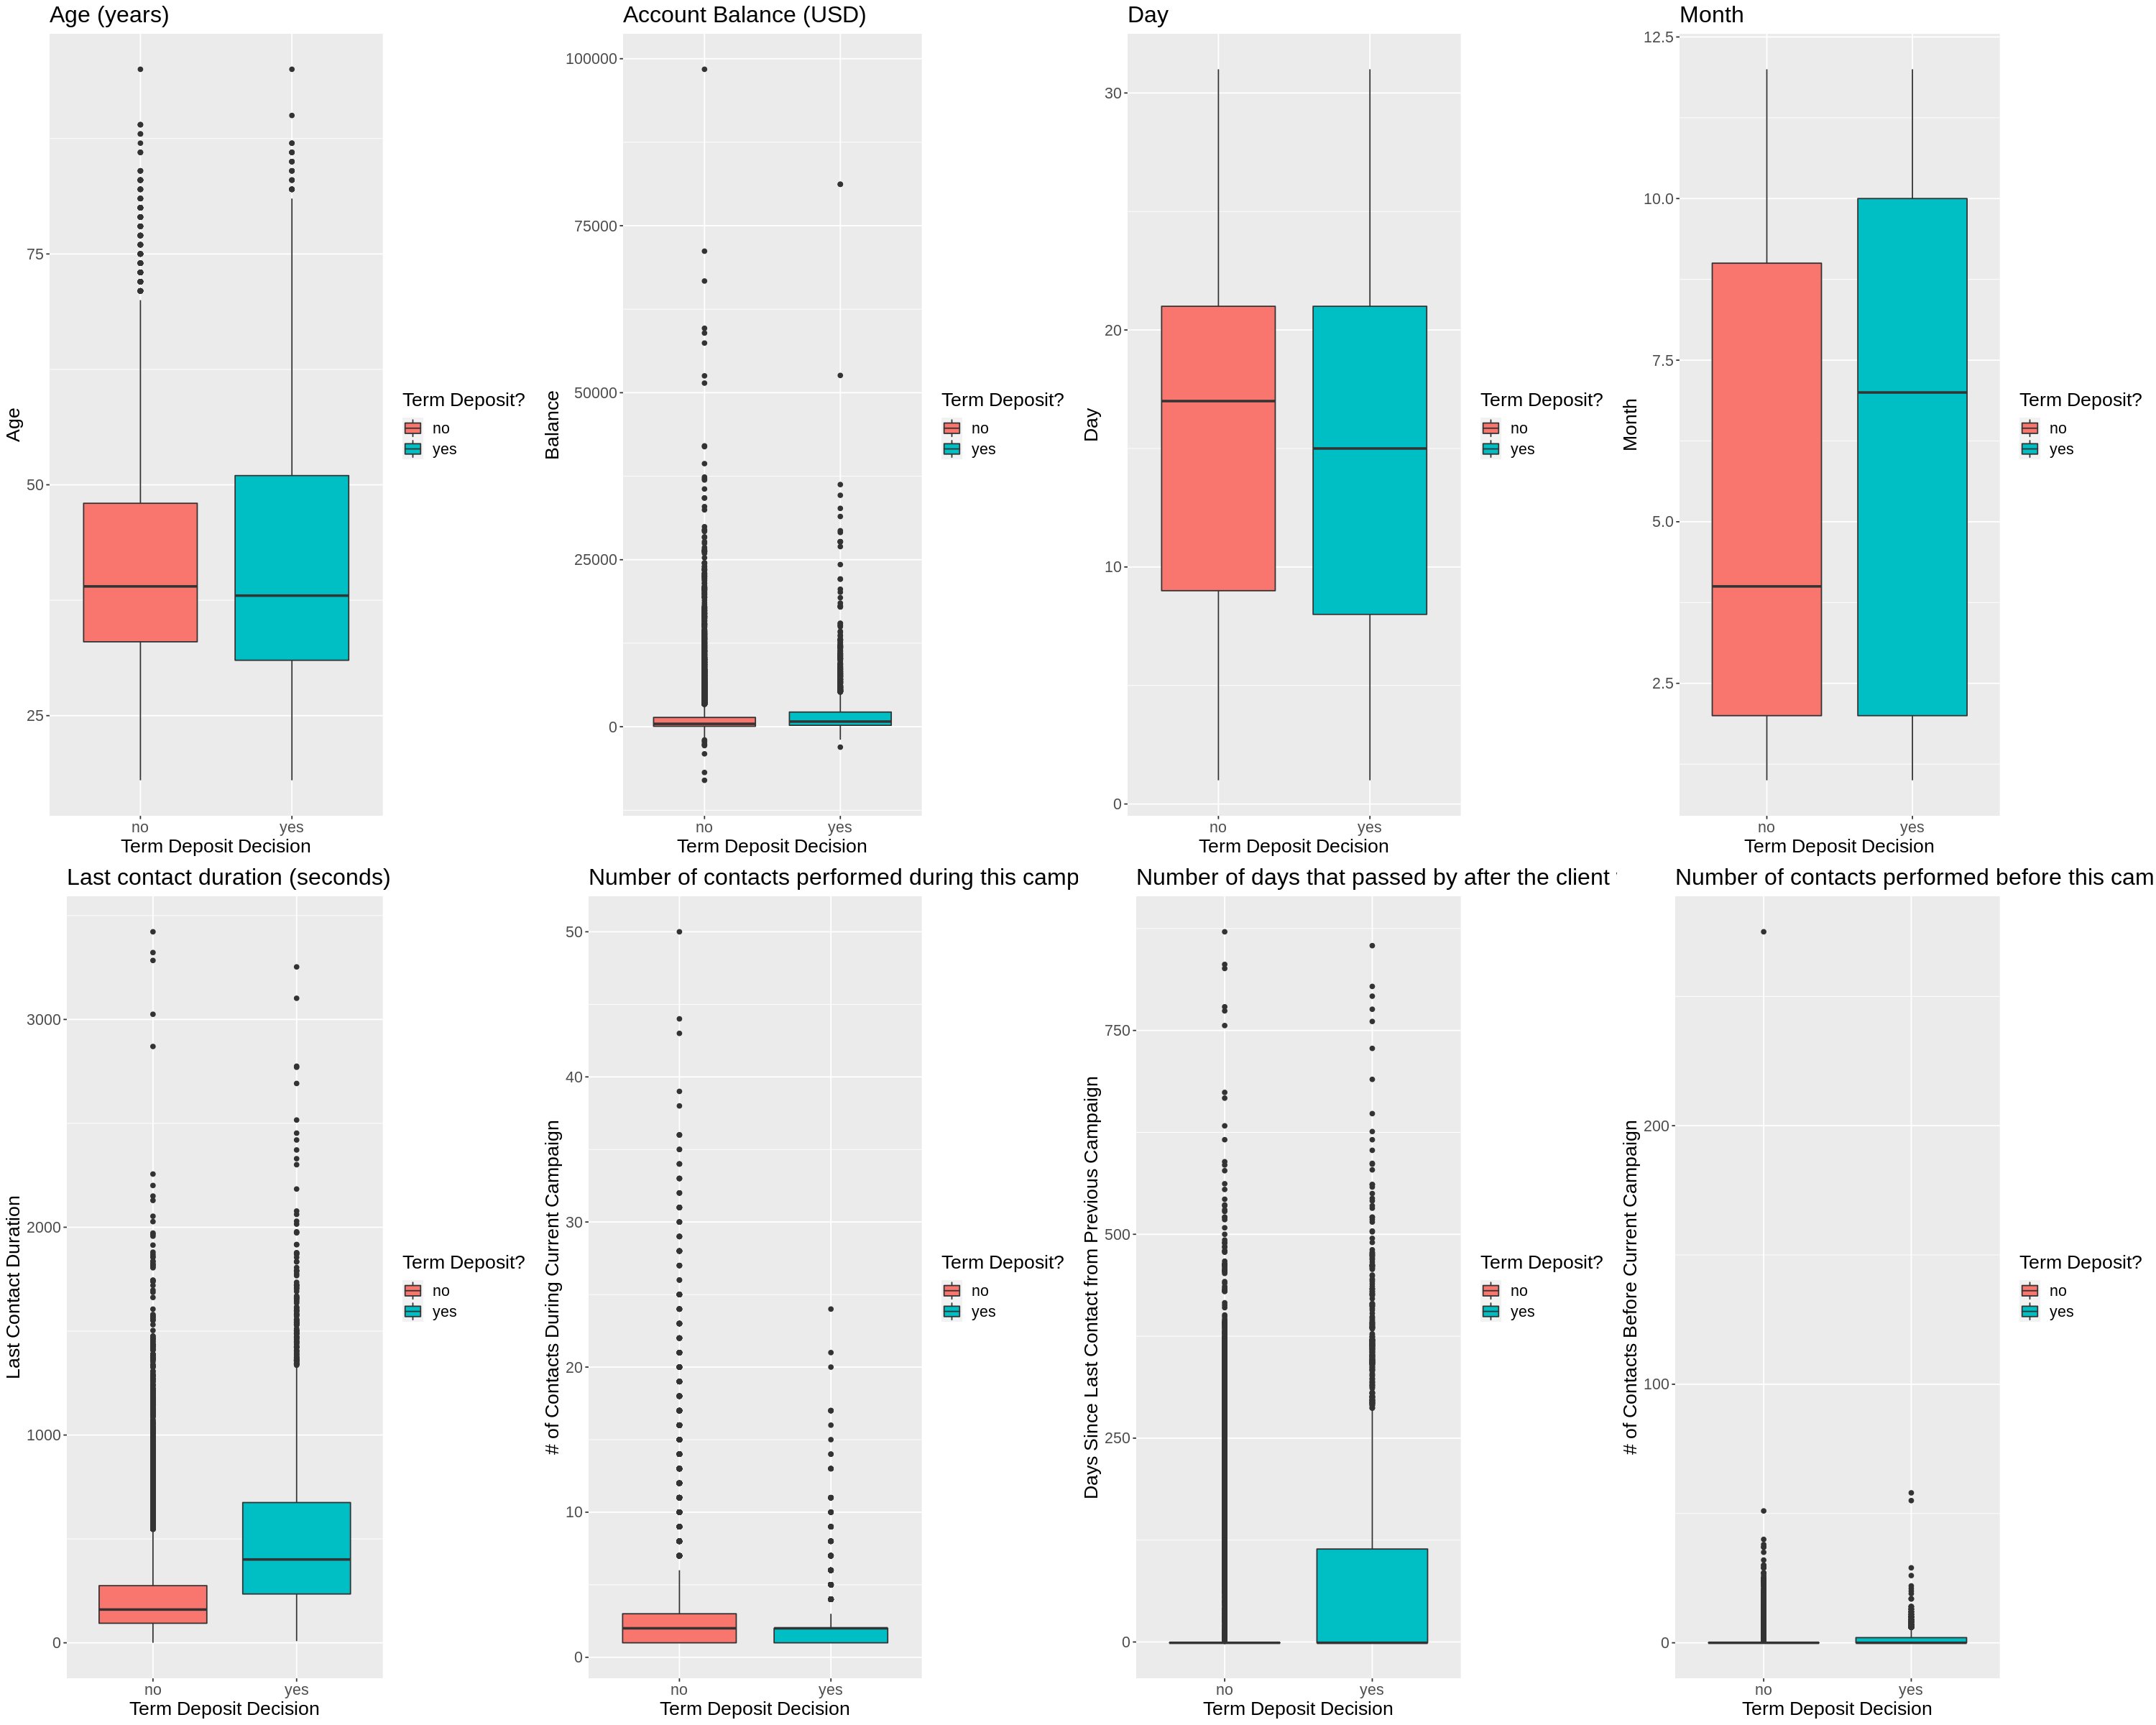

In [85]:
#Numerical Predictors

#Graph for Age
p_age <- ggplot(bank_train, aes(factor(y), age)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Age", fill = "Term Deposit?") +
    ggtitle("Age (years)")

#Graph Balance
p_balance <- ggplot(bank_train, aes(factor(y), balance)) + 
    geom_boxplot(aes(fill = factor(y)))+ 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Balance", fill = "Term Deposit?") +
    ggtitle("Account Balance (USD)")

#Graph Day
p_day <- ggplot(bank_train, aes(factor(y), day)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Day", fill = "Term Deposit?") +
    ggtitle("Day")

#Graph Month
p_month <- ggplot(bank_train, aes(factor(y), month)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Month", fill = "Term Deposit?") +
    ggtitle("Month")

#Graph Last contact duration
p_duration <- ggplot(bank_train, aes(factor(y), duration)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Last Contact Duration", fill = "Term Deposit?") +
    ggtitle("Last contact duration (seconds)")

#Graph Campaign
p_campaign <- ggplot(bank_train, aes(factor(y), campaign)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "# of Contacts During Current Campaign", fill = "Term Deposit?") +
    ggtitle("Number of contacts performed during this campaign and for this client")

#Graph Pdays
p_pdays <- ggplot(bank_train, aes(factor(y), pdays)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "Days Since Last Contact from Previous Campaign", fill = "Term Deposit?") +
    ggtitle("Number of days that passed by after the client was last contacted from a previous campaign")

#Graph Previous
p_previous <- ggplot(bank_train, aes(factor(y), previous)) + 
    geom_boxplot(aes(fill = factor(y))) + 
    theme(text = element_text(size = 16)) +
    labs(x = "Term Deposit Decision", y = "# of Contacts Before Current Campaign", fill = "Term Deposit?") +
    ggtitle("Number of contacts performed before this campaign and for this client")

grid.arrange(p_age,
             p_balance,
             p_day,
             p_month,
             p_duration,
             p_campaign,
             p_pdays,
             p_previous,
             nrow = 2)

**Figure 2: Boxplots of each numerical variable**

The box plots above can give us some insight into the distributions of our numerical variables, although some of them are not very clear due to the large amount of outliers (e.g. balance, previous). Duration seems to be the predictor with the largest difference in distributions between the term deposit decision values, so it will likely be a good predictor for us to choose. It also seems like day and month have a a small difference between their distributions, however the date of contact does not seem to be very important for predicting the decision to subscribe to a term deposit, and could possibly be skewed based on when the campaigns were run in the past, thus they will not be included as predictors. From the remaining variables, it seems like age and campaign have a small difference between their distributions, but more analysis needs to be done before choosing the final predictors for the model

In [86]:
# Find the number of occurrences of each value of y to determine if there is a class imbalance
total_rows <- nrow(bank_data_filtered)
y_occurrence <- bank_data_filtered %>%
    group_by(y) %>%
    summarize(n = n(), n_percent = n()/total_rows)
y_occurrence


`summarise()` ungrouping output (override with `.groups` argument)



y,n,n_percent
<chr>,<int>,<dbl>
no,26394,0.8539813
yes,4513,0.1460187


**Table 7: Distribution of Term Deposit Decision Values**

From the table above, we can see that our dataset is quite imbalanced, with 85% of the observations being for customers who did not subscribe to a term deposit. As such, we must upscale our training data that will be used to train our model later on.

<h2>2d) Choosing and Defining the Predictors</h2>

In [87]:
#Still have error exists here in this section of code
library(GGally)
options(repr.plot.width=18, repr.plot.height=18)
bank_scaled_data <- recipe(y ~ ., data = bank_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep() %>%
    bake(bank_train)

predictor_means <- bank_scaled_data %>%
   group_by(y) %>%
   summarize(across(age:previous, mean))

predictor_means_diff <- predictor_means %>%
    select(age:previous) %>%
    tibble::rownames_to_column() %>%  
    pivot_longer(-rowname) %>% 
    pivot_wider(names_from=rowname, values_from=value) %>%
    rename(no_mean = 2, yes_mean = 3) %>%
    mutate(means_diff=abs(no_mean - yes_mean)) %>%
    arrange(desc(means_diff))

predictor_means_diff

`summarise()` ungrouping output (override with `.groups` argument)



name,no_mean,yes_mean,means_diff
<chr>,<dbl>,<dbl>,<dbl>
duration,-0.16447266,0.9618614,1.1263340
housing,0.05448266,-0.3186229,0.3731056
month,-0.04587097,0.2682605,0.3141315
campaign,0.03839203,-0.2245225,0.2629145
loan,0.03559143,-0.2081442,0.2437356
⋮,⋮,⋮,⋮
marital,0.021220443,-0.12410041,0.14532086
day,0.019567129,-0.11443157,0.13399870
age,-0.013449065,0.07865220,0.09210126


**Table 8: Difference in predictor means grouped by term deposit decision values**

From the table above, we can see that duration has the largest difference between its mean values out of all the variables by a significant margin. This means the average value of duration for customers that did subscribe to a term deposit is very different from the average value of duration for customers that didn't subscribe to a term deposit, which suggests that it would be a good predictor. Other than duration, it seems like the variables have somewhat similar differences between their mean values, so any predictor that isn't too low on the above table should be a decent predictor.


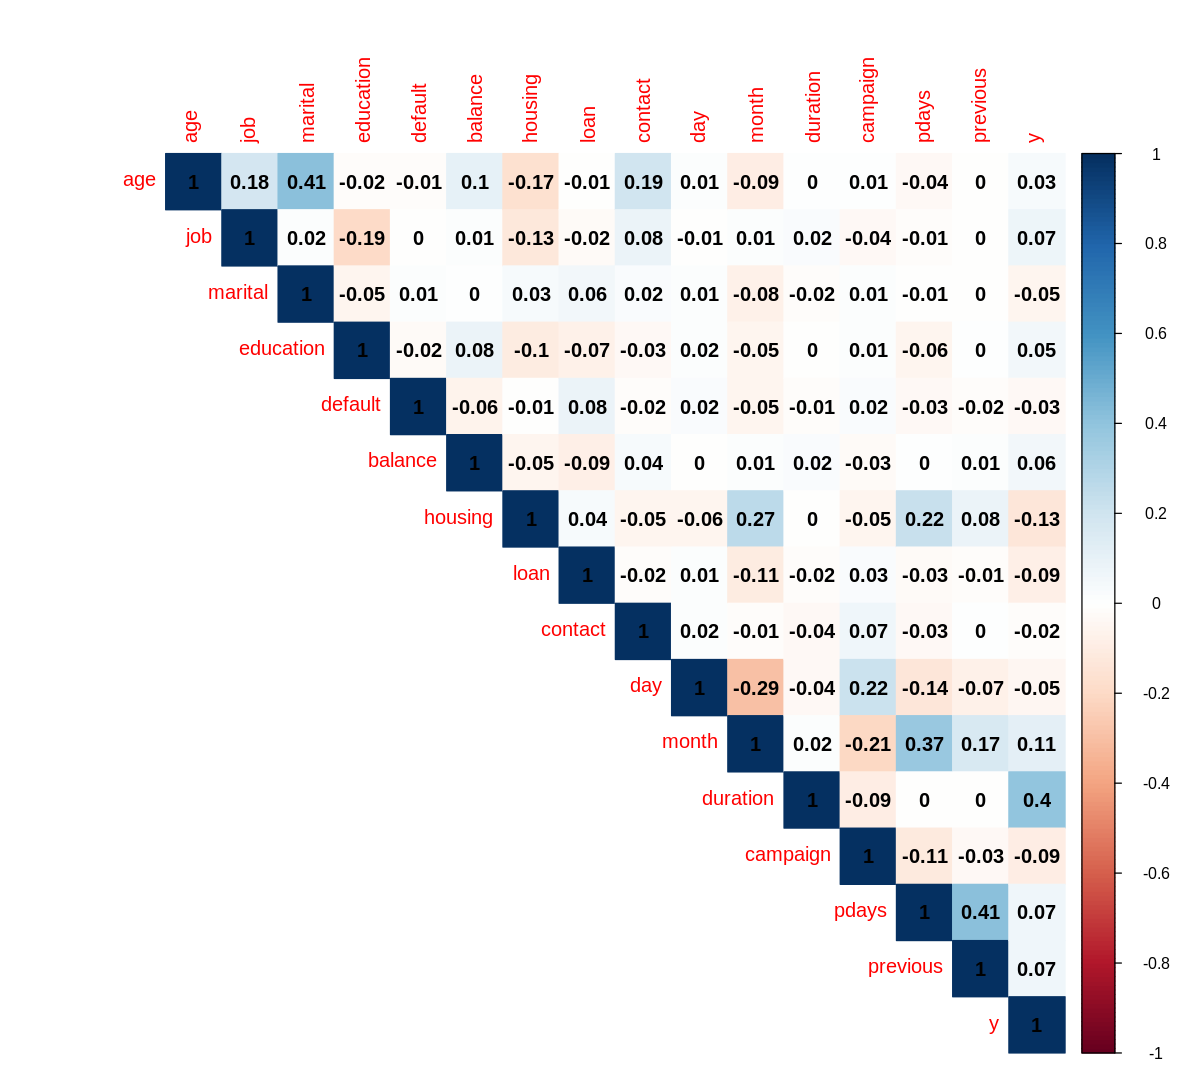

In [88]:
# Creating the correlation matrix 
options(repr.plot.height = 9, repr.plot.width = 10)

corr_data <- bank_train %>%
    mutate(y = as.double(unclass(y))) %>%
    cor(use = "pairwise.complete.obs")
# the second argument tells R to ignore specific column-row pairings that contain NA

corr_matrix <- corrplot(corr_data, method="color",  
                        type="upper", addCoef.col = "black")


**Figure 3: Correlation matrix of the predictors**

The correlation matrix above gives us an idea of which predictors would be most correlated with the 'y', the variable we are trying to predict. We can see that duration is the most highly correlated by far, and housing is the second most correlated after it. The rest of the variables do not have significant differences between their correlation values for 'y', so the predictors must be decided on after analysing all the info we have gathered so far.

Based on the observations made so far, we can see that duration is an obvious choice for one of our predictors. Housing also seems to be a good choice, as it is highly correlated with 'y' and has a large difference in mean values. Campaign will also be used as a predictor, due to its relatively large difference in mean values, and its relatively higher correlation value with y. As the number of predictors shouldn't be too large, to limit complexity and computation needed, just one more predictor will be chosen. Balance will be used as the last predictor, because although it doesn't have the largest difference in its mean values, nor a very significant correlation with y, it is one of the few numerical predictors available, and also has a very large distribution of its values. This should help offset the possible inaccuracies introduced by using categorical variables such as housing as part of our predictors. Another possible option that would have fit this same role was age, but as we can see from the figures above, it is not as correlated with y as compared to balance, thus balance was chosen over age to be used as a predictor

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



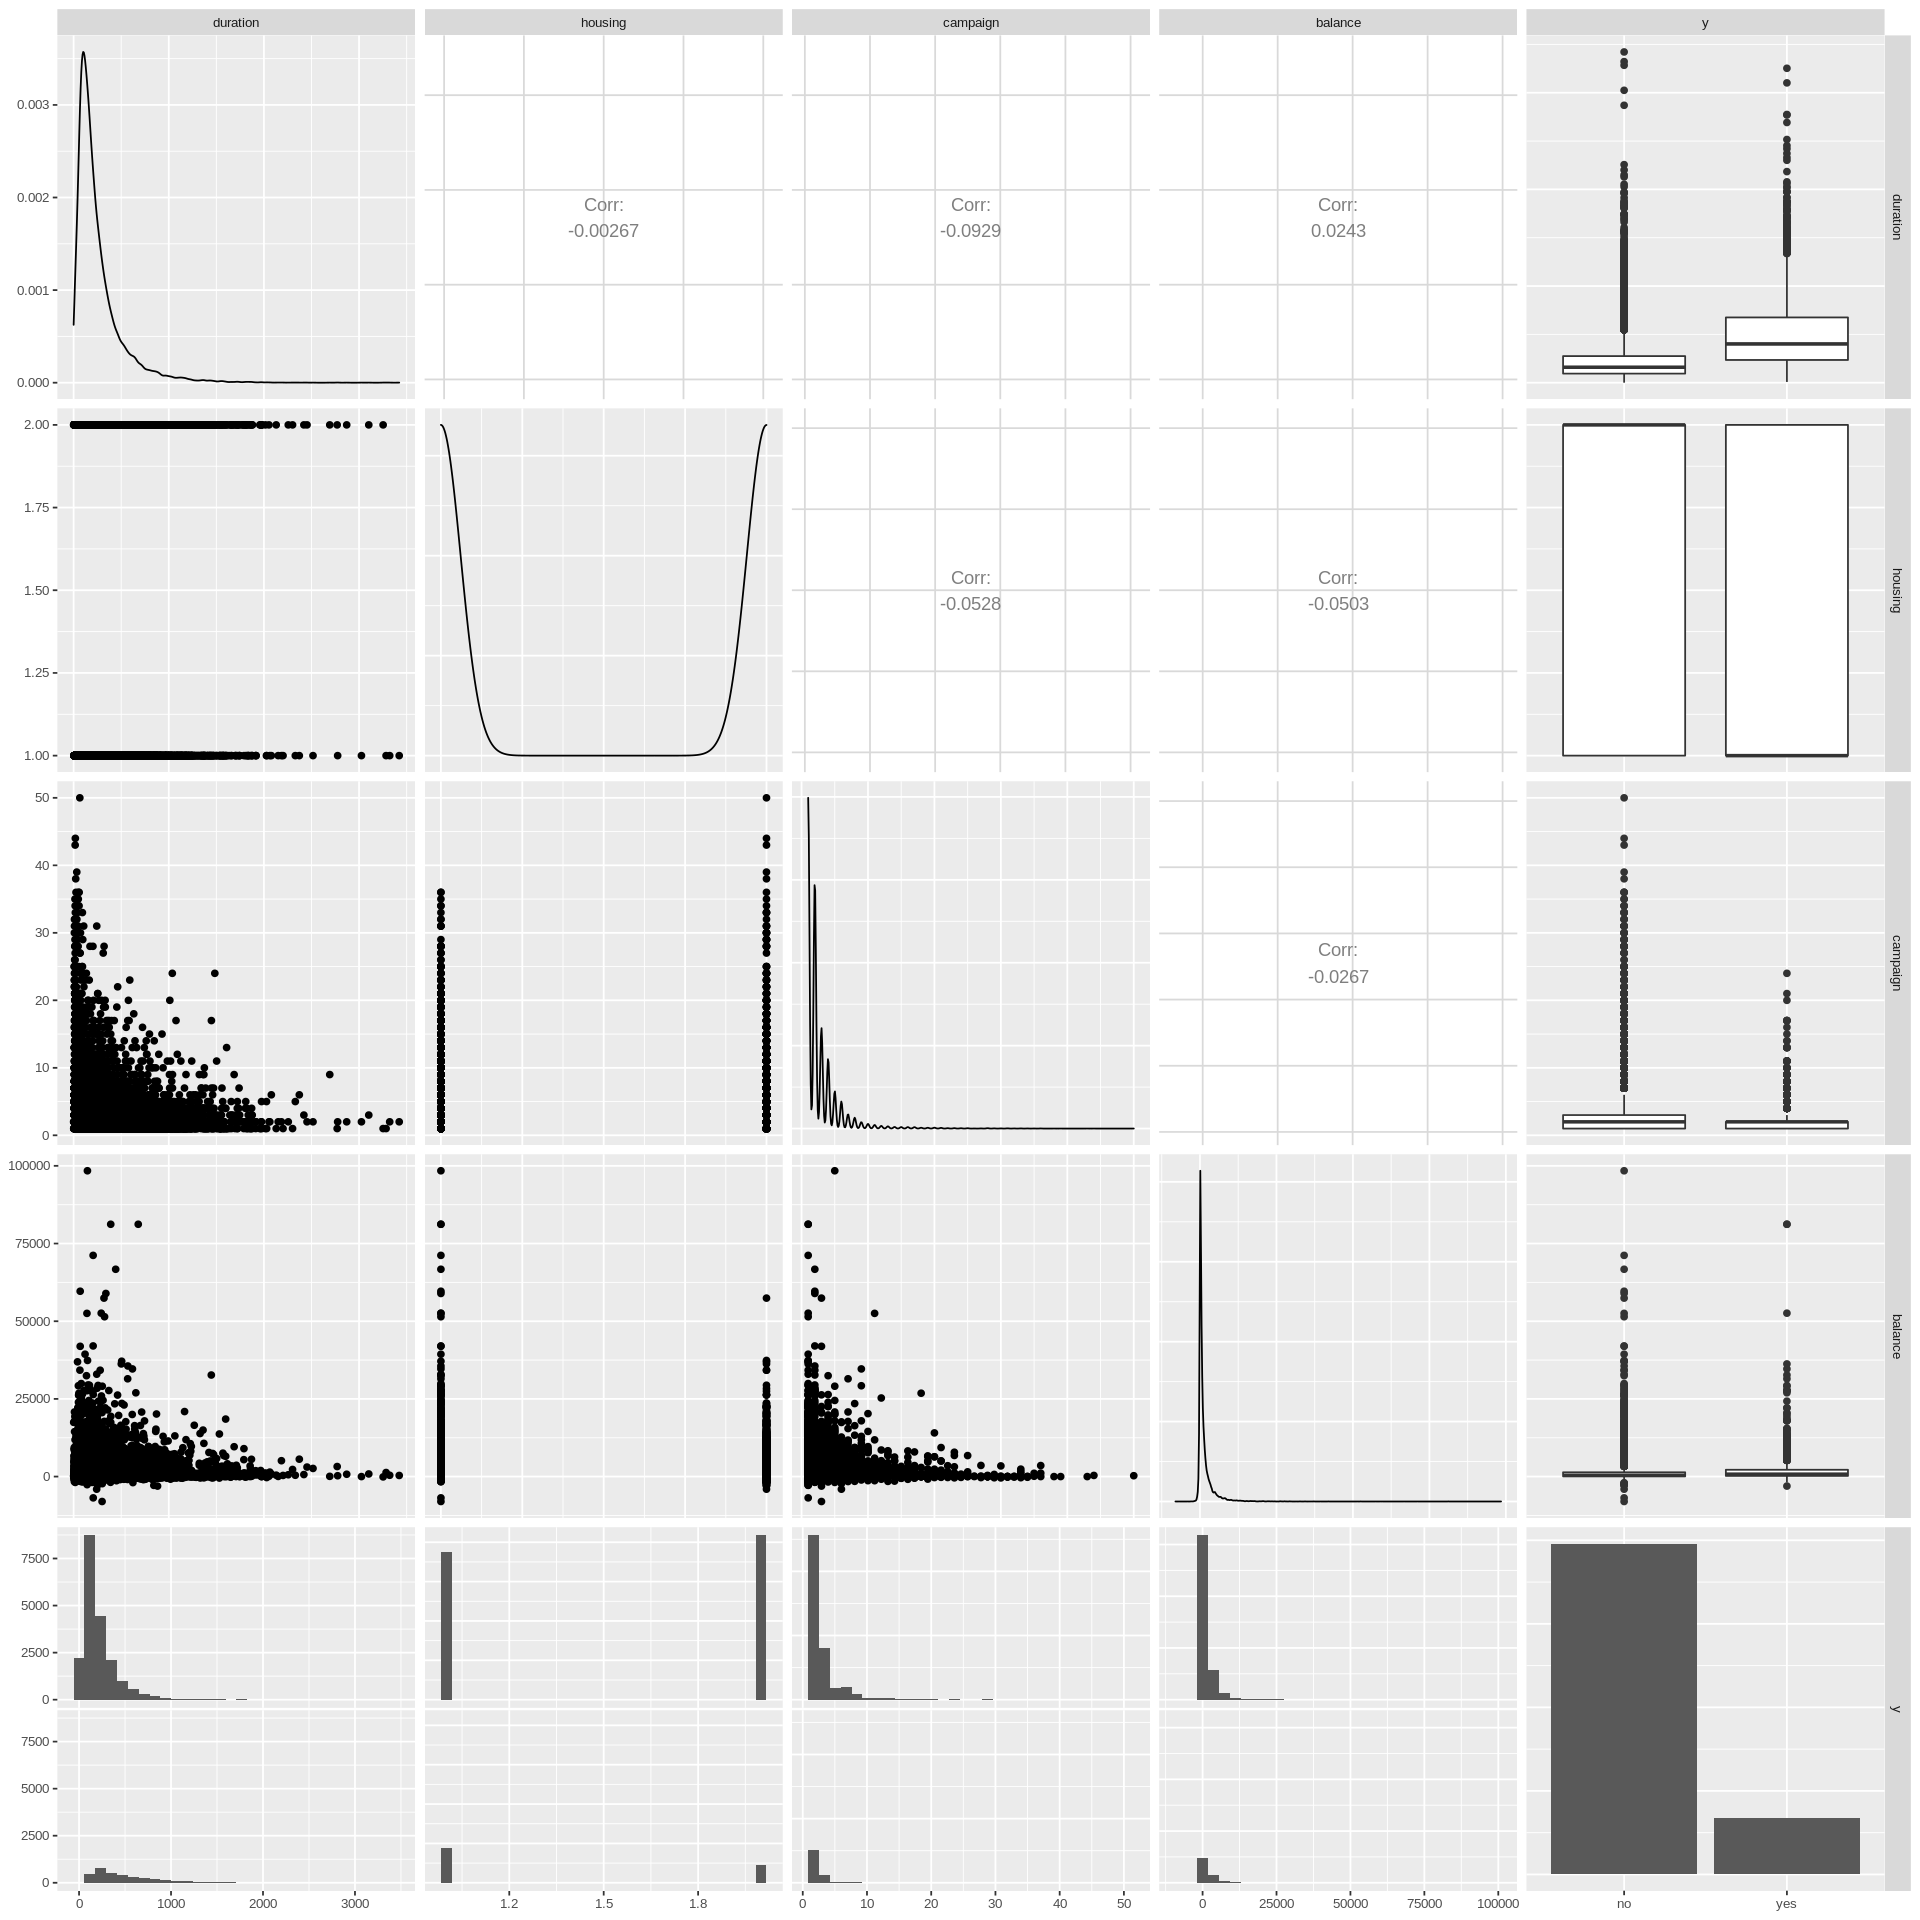

In [89]:
options(repr.plot.height = 16, repr.plot.width = 16)

bank_train <- select(bank_train, duration, housing, campaign, balance, y)
plot_pairs_bank_train <- bank_train %>%
  ggpairs +
  theme(text = element_text(size = 10))
plot_pairs_bank_train

**Figure 4: Summary of the final predictors**

One thing to note about the plots above is that the predictors mostly seem to be heavily skewed towards lower values. This means that our trained model may not be as accurate for observations with high-value predictors, however this should not be much of an issue as such observations would be much more unlikely due to their predictors beinng outliers

<h2>3a) Methods</h2>


We will use the four predictors selected above to train a KNN classification model which will be used in order to predict whether or not a given client would subscribe to a term deposit subscription. The classification model will be built according to the following steps.

i. **Preprocessing**: Upsampling, scaling, and centering predictors

ii. **Tuning the Classifier**: Performing cross-validation on possible values of K.

iii. **Training the Model**: Train the classification model with the value of K determined above.

iv. **Evaluating Accuracy**: Predict the labels of the testing set with the trained model and compute the accuracy of the predictions

<h3>i) Preprocessing</h3>

In [107]:
# Upsample, scale, and center all predictors
bank_k_data <- recipe(y ~ duration+housing+campaign+balance, data = bank_train) %>%
    step_upsample(y, over_ratio=1, skip = FALSE) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep() %>%
    bake(bank_train)

# Validate the dataset after upsampling is balanced
total_rows <- nrow(bank_k_data)
validate_balance <- bank_k_data %>%
    group_by(y) %>%
    summarize(n = n(), n_percent = n()/total_rows)
validate_balance

`summarise()` ungrouping output (override with `.groups` argument)



y,n,n_percent
<fct>,<int>,<dbl>
no,19796,0.5
yes,19796,0.5


**Table 9: Distribution of the term deposit decision values in the training set after upsampling**

As we discovered earlier, the original dataset is heavily imbalanced, with just around 10% of the observations being for people who agreed to a term deposit subscription. In order to avoid possible inaccuracies in the model due to this imbalance, we upsample our training set here in order to fix the imbalance. The table above verifies that the upscaled training set is balanced correctly.

<h3>ii) Tuning the Classifier</h3>

In [100]:
# Perform cross validation to determine the ideal # of neighbours

# Set the seed
set.seed(7134) 

# No need to use the entire dataset for this, 
# especially since cross validation would take too long on a datset so large
bank_sample <- rep_sample_n(bank_k_data, 1000)

# Since bank_k_data is already preprocessed, no need to do any preprocessing on this recipe
bank_k_recipe <- recipe(y ~ duration+housing+campaign+balance, data = bank_sample)

bank_vfold <- vfold_cv(bank_sample, v = 5, strata = y)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

bank_knn_results <- workflow() %>%
       add_recipe(bank_k_recipe) %>%
       add_model(knn_spec) %>%
       tune_grid(resamples = bank_vfold, grid = 20) %>%
       collect_metrics()

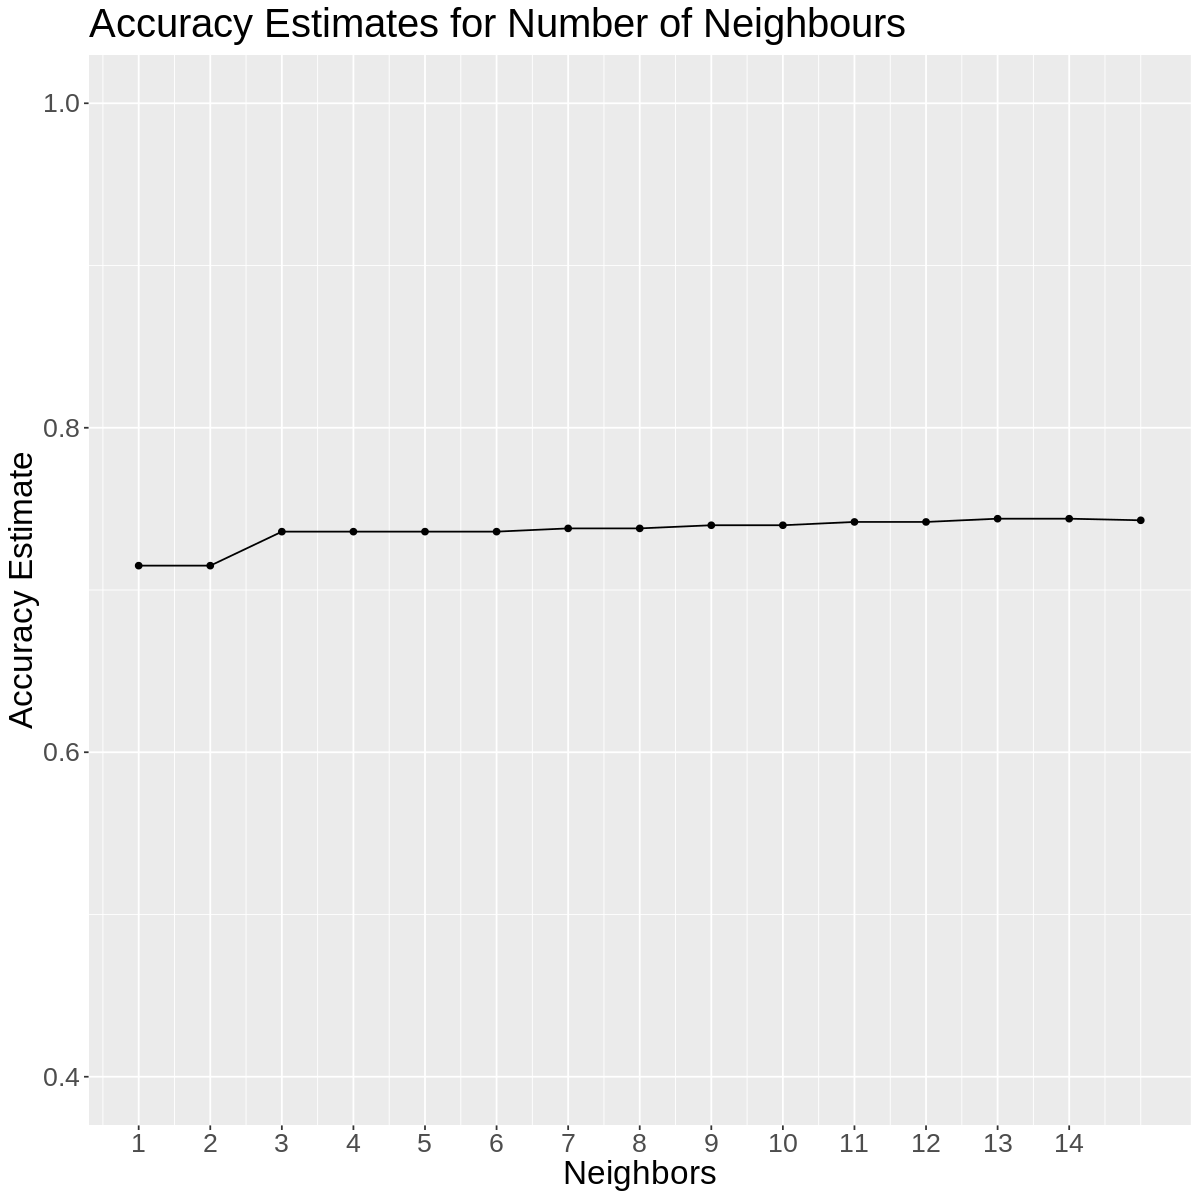

In [101]:
# Plot the accuracies of each k determined by cross validation
# to find the ideal value of k
options(repr.plot.width=10, repr.plot.height=10)

accuracies <- bank_knn_results %>% 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Accuracy Estimates for Number of Neighbours") +
       theme(text = element_text(size = 20)) +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

**Figure 5: Accuracy estimates for various values for the number of neighbours to use in the model**

From the above plot, we can see that the accuracy increases greatly from k=2 to k=3, and from there increases slowly up until k=11. The increase in accuracy from k=3 to k=11 is not very large, while the increase in neighbours would greatly increase the amount of computation needed, therefore we will choose k=3.

<h3>iii) Training the Model</h3>

In [102]:
# Use k=3 determined above to train the final classification model
bank_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
       set_engine("kknn") %>%
       set_mode("classification")

bank_fit <- workflow() %>%
        add_recipe(bank_k_recipe) %>%
        add_model(bank_spec) %>%
        fit(data = bank_upscaled_train)

<h3>iv) Evaluating Accuracy</h3>

In [103]:
bank_predictions <- predict(bank_fit , bank_test) %>%
       bind_cols(bank_test)
bank_predictions

.pred_class,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
yes,43,1,1,1,1,105,1,1,1,4,1,668,2,-1,0,no
no,44,2,1,2,1,1146,1,2,1,4,1,178,2,-1,0,no
no,54,2,1,1,1,187,1,1,1,4,1,273,3,-1,0,no
no,44,3,1,1,1,93,1,2,1,7,1,125,2,-1,0,no
yes,51,2,1,1,1,216,1,2,1,7,1,615,2,-1,0,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
yes,36,10,2,1,1,1224,2,2,1,12,4,482,1,374,1,yes
yes,66,9,1,1,1,3409,1,2,1,15,4,414,2,27,6,no
yes,34,2,1,1,1,133,1,2,1,15,4,401,2,187,5,yes


**Table 10: Results of applying the classification model on the testing dataset**

In [104]:
bank_metrics <- bank_predictions %>%
         metrics(truth = y, estimate = .pred_class)
bank_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7621020
kap,binary,0.2477886


**Table 11: Final metrics of the classification model**

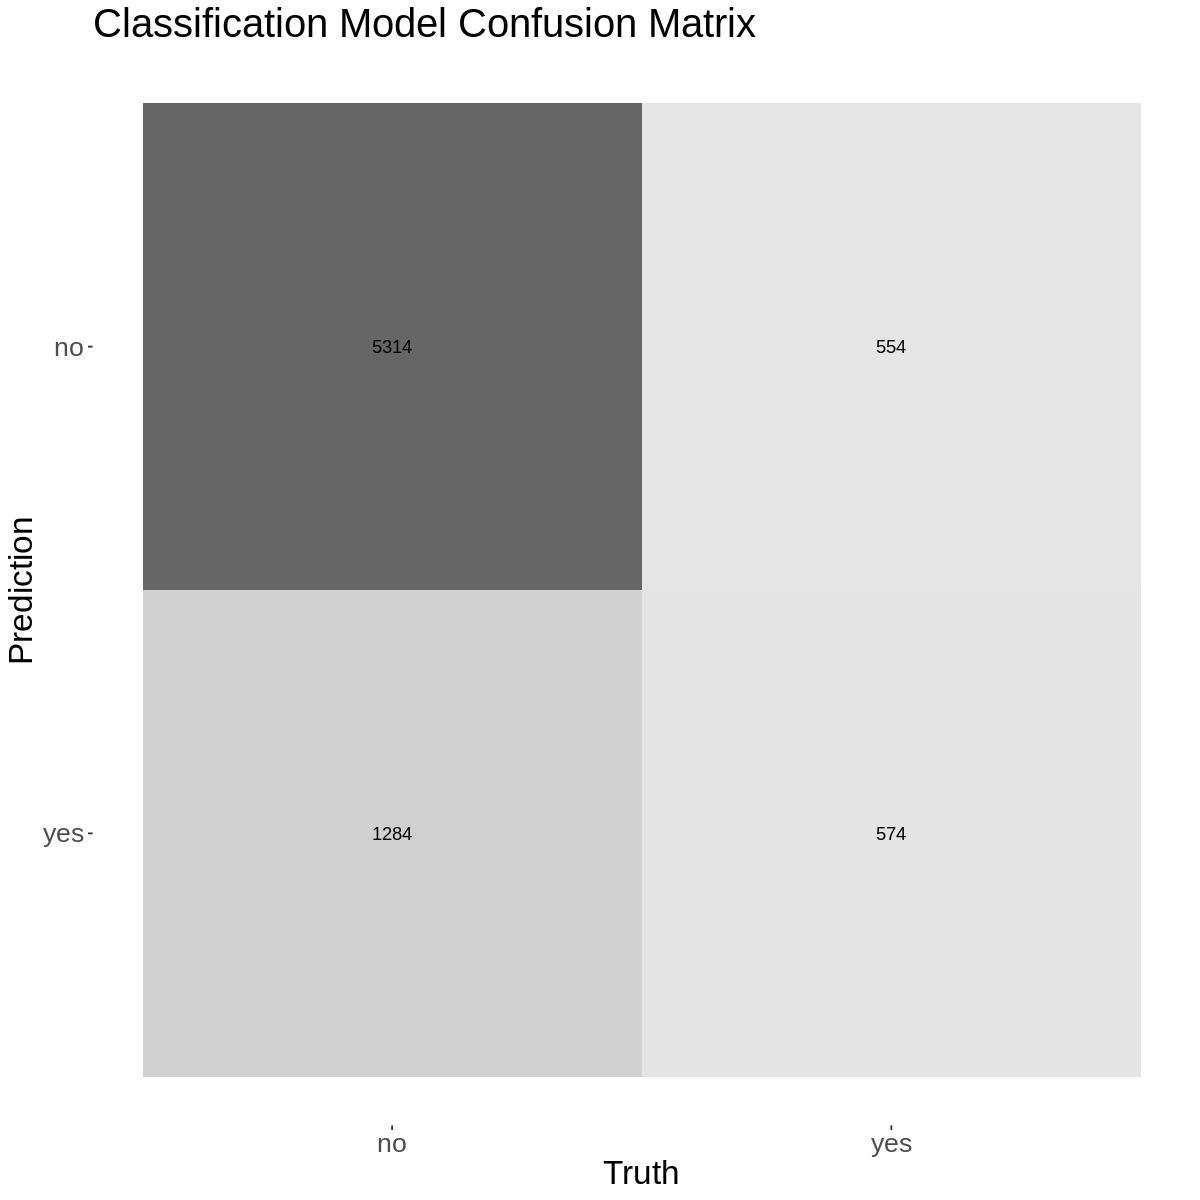

In [105]:
options(repr.plot.width=10, repr.plot.height=10)

bank_conf_mat <- bank_predictions %>% 
       conf_mat(truth = y, estimate = .pred_class)

autoplot(bank_conf_mat, 
         type = "heatmap", 
         label.size=20, 
         loadings.label.size=20) +
         theme(text = element_text(size=20)) +
         ggtitle("Classification Model Confusion Matrix")

**Figure 6: Heatmap visualization of the classification model results**

From the heatmap above, we can see that although it has a very high rate of predicting 'no' correctly, it was only able to predict 1283 'yes' data points correctly out of 1857 points. This would be an accuracy of ~69%, and while that isn't bad, it's a decent amount lower than the reported accuracy of 76% of our predictor.

<h2> Discussion & Results </h2>
    
    
**Summarize what you found and discuss whether this is what you expected to find**


Our results show that a multivariate KNN classifier using K=3 neighbours predicts outcomes in our banking data set with the highest accuracy level (estimated 0.75). Increases in k beyond this level delivered decreasing marginal improvements in accuracy. To reiterate, the predictors used in our classifier are “duration”, “housing”, and “campaign” based on their large differences in mean values. The fourth predictor “balance” is used to offset inaccuracies caused by using categorical variables in our classification. 

Furthermore, our tables displaying counts by predictor variable highlight an imbalance in our data, with most of the points falling under the class of “no” under the “y” variable (i.e. people who did not subscribe to a term deposit). This is also shown in our confusion matrix, which illustrates a similar imbalance carried over into our predictor, resulting in a high classification rate for “no” data points, but only ~69% for “yes” points. 

Additionally, with regards to the confusion matrix we found that roughly 16% of all the "yes" decisions that were predicted were in realtiy a "no" answer and 7% of all "no" answers that were predicted were acutally a "yes". This is troublesome to see espically for the "yes" answer when in reality it is a "no" as trying to provide a customer with a service that they do not want and have said no to is bad business practice and will hurt the reputation of the bank.

These findings run somewhat contrary to our general understanding regarding the popularity of term deposits. The frequency of term deposits made by clients vary depending on the terms of such an account (i.e. length of time during which a customer agrees not to withdraw funds in return for a higher rate of interest paid on their account). Generally, term deposits are very safe investments and generally attract conversative, low risk investors (Chen, 2020). Thus, while they may not be considered the most popular investment option, term deposit accounts are still viable and stable options for groups such as retirees, so our finding that a disproportionate number of clients decided not to open an account presents a slight discrepancy. An explanation for this could be a result of the time frame during which the original data was recorded. The Portugese banking institution ran this marketing campaign from May 2008 to November 2010, right in the heat of the US Financial Crisis. There is a high chance that the effects of the crisis spilled over into investors in Portugal and deterred many from trusting in banking institutions, let alone opening new accounts with such maturity dates (Chen et al., 2018). 


**Discussion what impact could such findings have**

In any case, we believe that our findings from this research provide insights to banking institutions worldwide as to how to effectively strategize marketing efforts to gain more clientele and incentivize more participation in bank term deposits. Our analysis to determine which variables are the most relevant in determining the outcome of a client’s behaviour alone gives a great deal of information to banks as to how they could target marketing campaigns or promotions. For instance, our boxplots graphing the relationship between each variable and its class show that “duration” has a large difference in density of “yes” and “no”. This suggests the “duration” variable is a viable indicator for customer success, so banks could implement programs that reward salespeople based on the amount of time they interact with clients (since higher duration can lead to more success in getting a customer a term deposit). 

**Discussion  what future questions could this lead to**

Further research on other variables that affect the outcome of a client’s decision could be conducted to gather a more holistic view of a prospective customer’s behaviour. For instance, banks could factor in data from international banks and institutions to better predict trends that come from investors overseas. Data on characteristics like exchange rates and domestic interest rates could provide insights on how an individual from France may view Portugese investment opportunities as compared to someone from the United States. Questions related to this could be 
Do the nationalities of investors and global market trends have an influence on the proportion of term deposit accounts opened at a Portugese banking institution?
How do interest rates and exchange rates impact the success of a domestic bank?


<h2> References </h2>

1) Chen, James. “Term Deposit Definition.” Investopedia, Investopedia, 16 Sept. 2020, www.investopedia.com/terms/t/termdeposit.asp.<br />
<br />
2) Chen, Wenjie, et al. “Lasting Effects: The Global Economic Recovery 10 Years After the Crisis.” IMF Blog, International Monetary Fund, 13 Mar. 2019, blogs.imf.org/2018/10/03/lasting-effects-the-global-economic-recovery-10-years-after-the-crisis/#:~:text=In the year following the,all countries in the world.&text=Moreover, there are also signs,well as on income inequality.<br />